# **Table of Contents** <a class="anchor" id="0.1"></a>

- [1. Preprocess Data](#1)
    - [1.1 Data formating](#1.1)
    - [1.2 Outliers](#1.2)
    - [1.3 Missing values](#1.3)
- [2. Transforms data](#2)
    - [2.1 Aggregation](#2.1)
    - [2.2 Logarithmization of variables](#2.2)
    - [2.2 Handle with categorical features](#2.3)
    - [2.3 Polynomial features](#2.4)
- [3. LightGBM](#3)

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import shapiro
from scipy import stats
import os
print(os.listdir("house-prices-advanced-regression-techniques/"))

['test.csv', 'data_description.txt', 'train.csv', 'sample_submission.csv']


In [2]:
df_train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")

# 1. Preprocess Data <a class="anchor" id="1"></a>
## 1.1 Data formating <a class="anchor" id="1.1"></a>

'MSSubClass' - Identifies the type of dwelling involved in the sale. It is categorical feature despite Integer type. Before making one-hot encoding, use this feature to fill missed values in "Lot Frontage" and "BsmUnfSF", because seeing on boxplot we can see statistically significant difference between boxplots. 

In [3]:
df_train.MSSubClass.isnull().sum()

0

In [4]:
def fill_missing_with_mode_group(df, column):#разные/равные медианы в test & train ?
    groups = df["MSSubClass"].unique()
    for group in groups:
        median_in_group = df[df["MSSubClass"] == group][column].median()
        df.loc[df["MSSubClass"] == group, column] = df.loc[df["MSSubClass"] == group, column].fillna(median_in_group)
        

fill_missing_with_mode_group(df_train, 'LotFrontage')
fill_missing_with_mode_group(df_train, 'BsmtUnfSF')

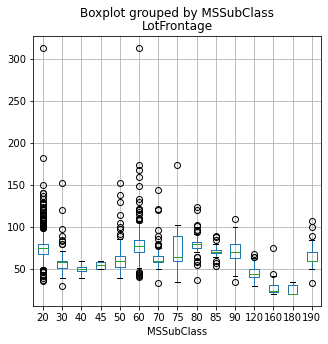

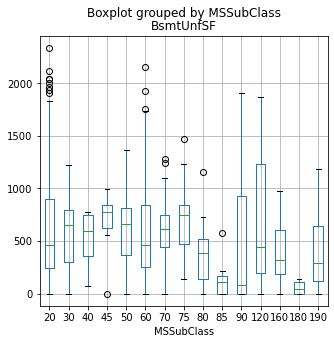

In [5]:
for item in ['LotFrontage',"BsmtUnfSF"]:
    display(df_train.boxplot(item, by="MSSubClass",figsize=(5,5)))

In [6]:
def formating_1(data):
    data = pd.concat([data, pd.get_dummies(data['MSSubClass'])], axis=1).drop('MSSubClass', axis=1)
    data.rename(columns={20:"1-STORY 1946 & NEWER ALL STYLES",
                         30:"1-STORY 1945 & OLDER",
                         40:"1-STORY W/FINISHED ATTIC ALL AGES",
                         45:"1-1/2 STORY - UNFINISHED ALL AGES",
                         50:"1-1/2 STORY FINISHED ALL AGES",
                         60:"2-STORY 1946 & NEWER",
                         70:"2-STORY 1945 & OLDER",
                         75:"2-1/2 STORY ALL AGES",
                         80:"SPLIT OR MULTI-LEVEL",
                         85:"SPLIT FOYER",
                         90:"DUPLEX - ALL STYLES AND AGES",
                         120:"1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
                         150:"1-1/2 STORY PUD - ALL AGES",
                         160:"2-STORY PUD - 1946 & NEWER",
                         180:"PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
                         190:"2 FAMILY CONVERSION - ALL STYLES AND AGES"}, 
                inplace=True)
    return(data)

df_train = formating_1(df_train)


Features 'Condition1' & 'Condition2' have the same unique values.   

In [7]:
pd.options.display.max_columns = None

def formating_2(data):
    data = pd.concat([data, pd.get_dummies(data['Condition1'])], axis=1).drop('Condition1', axis=1)
    uniq_val = data['Condition2'].unique()
    for val in uniq_val:
        data.loc[data['Condition2']==val, val] = 1
    data.drop('Condition2', axis=1, inplace=True)
    return(data)

df_train = formating_2(df_train)

df_train[['Artery','Feedr','Norm','PosA','PosN','RRAe','RRAn','RRNe']].head(2)

,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe
0,0,0,1,0,0,0,0,0
1,0,1,1,0,0,0,0,0


In [8]:
df_train.shape

(1460, 102)

Formatting qualitative features into numeric type

In [9]:
def convert_quality_into_numeric(data):
    data.ExterQual = data.ExterQual.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
    data.ExterCond = data.ExterCond.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
    data.BsmtQual = data.BsmtQual.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})#, np.nan:0})
    data.BsmtCond = data.BsmtCond.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})#, np.nan:0})
    data.BsmtExposure = data.BsmtExposure.map({'Gd':4,'Av':3, 'Mn':2, 'No':1})#, np.nan:0})

    data.BsmtFinType1 = data.BsmtFinType1.map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1})#, np.nan:0})
    data.BsmtFinType2 = data.BsmtFinType2.map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1})#, np.nan:0})

    data.HeatingQC = data.HeatingQC.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
    data.CentralAir = data.CentralAir.map({"N":0, "Y":1})
    data.KitchenQual = data.KitchenQual.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
    data.FireplaceQu = data.FireplaceQu.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})#, np.nan:0})
    data.GarageFinish = data.GarageFinish.map({'Fin':3, 'RFn':2, 'Unf':1})#, np.nan:0})
    data.GarageQual = data.GarageQual.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})#, np.nan:0})
    data.GarageCond = data.GarageCond.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})#, np.nan:0})
    data.PavedDrive = data.PavedDrive.map({'Y':3, 'P':2, 'N':1})
    data.PoolQC = data.PoolQC.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})#, np.nan:0})

convert_quality_into_numeric(df_train)


## 1.2 Outliers <a class="anchor" id="1.2"></a>

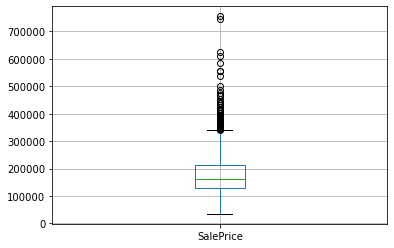

In [10]:
df_train.boxplot('SalePrice')

In [11]:
outliers_threshold = df_train.SalePrice.quantile(0.75) + 1.5 * (df_train.SalePrice.quantile(0.75) - df_train.SalePrice.quantile(0.25))

print(f"upper outliers threshold: {outliers_threshold},\n# outliers: {df_train.loc[df_train.SalePrice > outliers_threshold,'SalePrice'].count()}")

upper outliers threshold: 340037.5,
# outliers: 61


Consider 61 observations, which are determined by outliers from the analysis of the boxplot.

In [12]:
def describe_outliers(threshold, MSZoning='none'):
    print('outliers statistics:')
    display(df_train.loc[(df_train.SalePrice > threshold) & (df_train.MSZoning == MSZoning),:].describe().loc[["mean", 'std', 'min', '25%','50%','75%']])
    print('Not outliers statistics: ')
    display(df_train.loc[(df_train.SalePrice <= threshold) & (df_train.MSZoning == MSZoning),:].describe().loc[["mean", 'std', 'min', '25%','50%','75%']])
    print('Observation with max price:')
    display(df_train.loc[(df_train.SalePrice == max(df_train.SalePrice)) & (df_train.MSZoning == MSZoning),:].describe().loc[["mean"]])    

Рассмотрим "выбросы" по группам.

In [13]:
df_train.groupby("MSZoning").SalePrice.agg(["count","min","median","max"])

,count,min,median,max
MSZoning,,,,
C (all),10,34900,74700,133900
FV,65,144152,205950,370878
RH,16,76000,136500,200000
RL,1151,39300,174000,755000
RM,218,37900,120500,475000


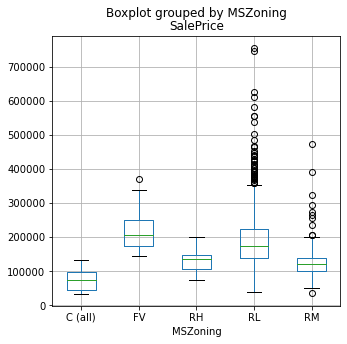

In [16]:
df_train.boxplot(column="SalePrice", by="MSZoning",figsize=(5,5))

In [17]:
def threshold_detector(MSZoning_type):
    IQR = df_train[df_train["MSZoning"] == MSZoning_type].SalePrice.quantile(.75) - df_train[df_train["MSZoning"] == MSZoning_type].SalePrice.quantile(.25)
    thresh_value = df_train[df_train["MSZoning"] == MSZoning_type].SalePrice.quantile(.75) + 1.5*IQR
    return(thresh_value)

rl_thresh = threshold_detector("RL")
rm_thresh = threshold_detector("RM")

MSZoning = "RL"

In [18]:
describe_outliers(rl_thresh, "RL")

outliers statistics:


,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,1-STORY 1946 & NEWER ALL STYLES,1-STORY 1945 & OLDER,1-STORY W/FINISHED ATTIC ALL AGES,1-1/2 STORY - UNFINISHED ALL AGES,1-1/2 STORY FINISHED ALL AGES,2-STORY 1946 & NEWER,2-STORY 1945 & OLDER,2-1/2 STORY ALL AGES,SPLIT OR MULTI-LEVEL,SPLIT FOYER,DUPLEX - ALL STYLES AND AGES,1-STORY PUD (Planned Unit Development) - 1946 & NEWER,2-STORY PUD - 1946 & NEWER,PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,2 FAMILY CONVERSION - ALL STYLES AND AGES,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn
mean,675.940000,89.080000,20324.000000,8.82000,5.120000,2000.460000,2003.860000,442.510204,4.440000,3.040000,4.760000,3.060000,3.020000,4.960000,1055.460000,1.160000,30.780000,806.260000,1892.500000,4.880000,1.0,1932.220000,539.92000,0.0,2472.140000,0.760000,0.020000,2.120000,0.640000,2.900000,1.0,4.620000,8.860000,1.300000,4.100000,2001.580000,2.700000,2.920000,809.000000,3.0,3.0,3.0,207.000000,83.340000,10.600000,6.080000,22.120000,11.100000,5.0,0.0,6.300000,2007.780000,439383.680000,0.540000,0.0,0.0,0.0,0.040000,0.380000,0.020000,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.980000,0.0,0.020000,0.0,0.020000,0.0,0.0
std,399.008844,27.229066,29707.160623,0.84973,0.798979,15.718454,7.599705,334.395171,0.611455,0.197949,0.476381,0.239898,1.133713,1.947893,651.254683,0.680936,139.089648,678.522729,444.461529,0.435187,0.0,353.779321,671.69043,0.0,652.622434,0.517451,0.141421,0.593846,0.484873,1.035098,0.0,0.567486,1.653814,0.505076,0.543984,12.942715,0.543984,0.274048,163.266278,0.0,0.0,0.0,167.109398,63.990309,49.741372,42.992092,61.272773,78.488853,NaN,0.0,2.844615,1.359622,92095.450836,0.503457,0.0,0.0,0.0,0.197949,0.490314,0.141421,0.0,0.0,0.0,0.0,0.141421,0.0,0.0,0.0,0.0,0.0,0.141421,0.0,0.141421,0.0,0.141421,0.0,0.0
min,54.000000,42.000000,8089.000000,7.00000,2.000000,1934.000000,1965.000000,0.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,32.000000,728.000000,3.000000,1.0,1264.000000,0.00000,0.0,1419.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,3.000000,5.000000,1.000000,3.000000,1934.000000,1.000000,2.000000,380.000000,3.0,3.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.0,0.0,1.000000,2006.000000,359100.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
25%,357.250000,69.000000,12393.000000,8.00000,5.000000,2003.000000,2003.250000,208.000000,4.000000,3.000000,5.000000,3.000000,2.250000,5.250000,493.250000,1.000000,0.000000,313.000000,1687.000000,5.000000,1.0,1729.500000,0.00000,0.0,1986.500000,0.000000,0.000000,2.000000,0.000000,2.000000,1.0,4.000000,8.000000,1.000000,4.000000,2003.000000,2.250000,3.000000,708.750000,3.0,3.0,3.0,121.000000,49.250000,0.000000,0.000000,0.000000,0.000000,5.0,0.0,4.000000,2007.000000,380250.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
50%,635.500000,88.000000,13792.000000,9.00000,5.000000,2006.000000,2006.000000,424.000000,4.500000,3.000000,5.000000,3.000000,3.000000,6.000000,1301.000000,1.000000,0.000000,540.000000,1924.000000,5.000000,1.0,1942.000000,0.00000,0.0,2348.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.0,5.000000,9.000000,1.000000,4.000000,2006.000000,3.000000,3.000000,816.500000,3.0,3.0,3.0,192.000000,73.500000,0.000000,0.000000,0.000000,0.000000,5.0,0.0,7.000000,2008.000000,402930

Not outliers statistics: 


,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,1-STORY 1946 & NEWER ALL STYLES,1-STORY 1945 & OLDER,1-STORY W/FINISHED ATTIC ALL AGES,1-1/2 STORY - UNFINISHED ALL AGES,1-1/2 STORY FINISHED ALL AGES,2-STORY 1946 & NEWER,2-STORY 1945 & OLDER,2-1/2 STORY ALL AGES,SPLIT OR MULTI-LEVEL,SPLIT FOYER,DUPLEX - ALL STYLES AND AGES,1-STORY PUD (Planned Unit Development) - 1946 & NEWER,2-STORY PUD - 1946 & NEWER,PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,2 FAMILY CONVERSION - ALL STYLES AND AGES,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn
mean,740.062670,73.620799,11174.348774,6.070845,5.554042,1974.326067,1984.832879,97.509572,3.382380,3.082652,3.580917,3.026193,1.691948,3.790458,466.949137,1.319288,54.506812,559.188919,1080.644868,4.144414,0.959128,1191.465940,314.772025,3.604905,1509.842870,0.451408,0.068120,1.576748,0.386921,2.926431,1.038147,3.504995,6.539510,0.661217,3.393939,1979.151284,1.860133,1.785649,477.354223,2.989534,2.986679,2.912807,100.507720,43.406903,17.178020,4.106267,16.602180,3.154405,3.500000,49.918256,6.317893,2007.826521,179725.308810,0.436876,0.029973,0.001817,0.003633,0.078111,0.230699,0.026340,0.005450,0.052679,0.018165,0.039055,0.052679,0.009991,0.0,0.014532,0.023615,0.060854,0.993642,0.007266,0.016349,0.008174,0.020890,0.001817,0.002725
std,421.034251,20.645238,8981.858533,1.277951,1.056596,25.824160,19.709786,156.465926,0.532591,0.335042,0.636183,0.275848,1.049680,1.987570,444.832826,0.911307,174.519676,443.257004,419.403124,0.954434,0.198083,357.558265,429.396329,38.693635,485.117592,0.524535,0.259179,0.538318,0.509163,0.758612,0.196325,0.631897,1.480642,0.644299,0.721306,22.343486,0.796683,0.702860,198.049016,0.197327,0.199555,0.388036,126.146701,59.430002,55.469739,32.144596,57.726705,43.141140,1.224745,558.160365,2.710709,1.332757,59248.359397,0.496225,0.170590,0.042601,0.060193,0.268468,0.421472,0.160216,0.073653,0.223494,0.133610,0.193815,0.223494,0.099499,0.0,0.119725,0.151915,0.239171,0.079518,0.084970,0.126870,0.090083,0.143081,0.042601,0.052152
min,1.000000,24.000000,2268.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,1908.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,2006.000000,39300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,373.000000,61.000000,8400.000000,5.000000,5.000000,1958.000000,1968.000000,0.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,216.000000,846.000000,3.000000,1.000000,923.000000,0.000000,0.000000,1141.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,3.000000,6.000000,0.000000,3.000000,1962.000000,1.000000,1.000000,358.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,5.000000,2007.000000,136500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,754.000000,75.000000,9

Observation with max price:


,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,1-STORY 1946 & NEWER ALL STYLES,1-STORY 1945 & OLDER,1-STORY W/FINISHED ATTIC ALL AGES,1-1/2 STORY - UNFINISHED ALL AGES,1-1/2 STORY FINISHED ALL AGES,2-STORY 1946 & NEWER,2-STORY 1945 & OLDER,2-1/2 STORY ALL AGES,SPLIT OR MULTI-LEVEL,SPLIT FOYER,DUPLEX - ALL STYLES AND AGES,1-STORY PUD (Planned Unit Development) - 1946 & NEWER,2-STORY PUD - 1946 & NEWER,PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,2 FAMILY CONVERSION - ALL STYLES AND AGES,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn
mean,692.0,104.0,21535.0,10.0,6.0,1994.0,1995.0,1170.0,5.0,3.0,5.0,3.0,4.0,6.0,1455.0,1.0,0.0,989.0,2444.0,5.0,1.0,2444.0,1872.0,0.0,4316.0,0.0,1.0,3.0,1.0,4.0,1.0,5.0,10.0,2.0,5.0,1994.0,3.0,3.0,832.0,3.0,3.0,3.0,382.0,50.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,2007.0,755000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In the case of "Outliers", there is a large std in the LotArea variable (area in sq.m.).

In [19]:
rl_outliers = df_train.loc[(df_train.SalePrice > rl_thresh) & (df_train.MSZoning == 'RL'),["LotArea",'OverallQual', 'OverallCond',"SalePrice"]]
#rl_outliers.head(15)

# OverallQual - [0, 10]
# OverallCond - [0, 10]

OverallCond is the same for all non-outliers
OverallQual for all> 7.0 [3 quantile not outliers]
SalePrice is noticeably more than 75% of non-outliers.

It was decided to determine observations with a small area (<= 13792) as outliers
Let's remove outliers.

In [20]:
display(rl_outliers[rl_outliers["LotArea"] <= 13792].describe().loc[["count","mean","std"]])
rl_outliers = rl_outliers[rl_outliers["LotArea"] <= 13792]
df_train.drop(axis = 0, index=rl_outliers.index, inplace=True)
print(f'number deleted observations: {rl_outliers.shape[0]}')

,LotArea,OverallQual,OverallCond,SalePrice
count,25.000000,25.00000,25.000000,25.000000
mean,11974.080000,8.84000,4.960000,408791.680000
std,1545.240648,0.85049,0.675771,54260.760228


number deleted observations: 25


In [21]:
#describe_outliers(rm_thresh, "RM")

All observations have OverallQual and OverallCond about 75% not outliers. Delete observations, with LotArea <8520

In [22]:
rm_outliers = df_train.loc[(df_train.SalePrice > rm_thresh) & (df_train.MSZoning == 'RM'),["LotArea",'OverallQual', 'OverallCond',"SalePrice"]]
rm_outliers = rm_outliers[rm_outliers["LotArea"] <= 8520]
df_train.drop(axis = 0, index=rm_outliers.index, inplace=True)
print(f'number deleted observations: {rm_outliers.shape[0]}')

number deleted observations: 5


## 1.3 Missing values <a class="anchor" id="1.3"></a>

In [23]:
def missing_ration(data, top=10):
    df_na = round((data.isnull().sum() / len(data)) * 100,2)
    df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame(
        {'Missing Ratio' :df_na}
    )
    print(missing_data)

def fill_missing(df, cols, val):
    """ Replace with the supplied val """
    for col in cols:
        df[col] = df[col].fillna(val)

def fill_missing_with_mode(df, cols):
    """ Replace with the mode """
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        
print("\n Train")
missing_ration(df_train)


 Train
              Missing Ratio
PoolQC                99.51
MiscFeature           96.22
Alley                 93.64
Fence                 80.35
FireplaceQu           48.18
GarageCond             5.66
GarageQual             5.66
GarageFinish           5.66
GarageYrBlt            5.66
GarageType             5.66
BsmtFinType2           2.66
BsmtExposure           2.66
BsmtFinType1           2.59
BsmtCond               2.59
BsmtQual               2.59
MasVnrArea             0.56
MasVnrType             0.56
Electrical             0.07


### Replace with  "Not exist"  
Reading 'data_description.txt' notice  that some there are some variables, which contains NA/None and it has meaning. Replace missing values with "Not exist"

In [24]:
fill_missing(df_train, ["MiscFeature", "Alley", "Fence", 
                        "GarageType","MasVnrType"], "Not exist")

### Replace with 0  
Missed values of Quantities features replace with 0.  
### Replace with mode  
Missed values of categorical variables replace with mode, because not many missing values. 

In [25]:
fill_missing(df_train, ['GarageYrBlt', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 
                        'BsmtFinSF1', 'GarageArea', 'TotalBsmtSF', 'GarageCars', 'BsmtFinSF2',
                       "PoolQC", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "BsmtQual", 
                        "BsmtCond","BsmtExposure","BsmtFinType1", "BsmtFinType2"], 0)


fill_missing_with_mode(df_train, ['Electrical', 'MSZoning', 'Functional', 'Utilities', 'Exterior1st', 'Exterior2nd', 
'KitchenQual', 'SaleType'])


# 2. Transforms data <a class="anchor" id="2"></a>

## 2.1 Aggregation <a class="anchor" id="2.1"></a>

In [26]:
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']


In [27]:
df_train["time_before_remodelation"] = df_train.YearRemodAdd - df_train.YearBuilt

## 2.2 Logarithmization of variables <a class="anchor" id="2.2"></a>  
Taking the logarithm of some variables allows their distribution to be closer to normal ('loglist' tuple was created by seeing histograms and shapiro test)

In [28]:
def add_logs(df, cols):
    # add Log transformed columns
    for c in cols:
        df[c] = np.log(df[c] + 1)
    return(df)

loglist = ('LotFrontage', 
           'LotArea', 'BsmtUnfSF','GrLivArea', 
           'BsmtFullBath', 'BsmtHalfBath','TotalSF')

df_train = add_logs(df_train, loglist)

In [29]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

## 2.3 Handle with categorical features <a class="anchor" id="2.3"></a>

In [30]:
def fix_missing_cols(in_train, in_test):
    missing_cols = set(in_train.columns) - set(in_test.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        in_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    in_test = in_test[in_train.columns]
    return(in_test)

def dummy_encode(in_df_train):
    df_train = in_df_train
    categorical_feats = [
        f for f in df_train.columns if df_train[f].dtype == 'object'
    ]
    print(categorical_feats)
    for f_ in categorical_feats:
        prefix = f_
        df_train = pd.concat([df_train, pd.get_dummies(df_train[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        
    return(df_train)

In [31]:
df_train = dummy_encode(df_train)
df_train_here = df_train
print("Shape train: %s, test: %s" % (df_train.shape))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Shape train: 1430, test: 251


## 2.4 Polynomial features  <a class="anchor" id="2.4"></a>
Make polynomial features of variables, which have high correlation coefficient with Dependent Variable

In [32]:
def load_poly_features(data, cols):
    print('Loading polynomial features..')
    # Make a new dataframe for polynomial features
    poly_features = data[cols]

    # imputer for handling missing values
    imputer = SimpleImputer(strategy='median')

    # Need to impute missing values
    poly_features = imputer.fit_transform(poly_features)

    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree=3)
    # Train the polynomial features
    poly_features = poly_transformer.fit_transform(poly_features)


    print('Polynomial Features shape: %s' % str(poly_features.shape))

    df_poly_features = pd.DataFrame(poly_features,
                                    columns=poly_transformer.get_feature_names(cols))

    df_poly_features['Id'] = data['Id']
 
    print('Loaded polynomial features')
    return(df_poly_features)

In [33]:
corr_list = abs(df_train.corr().SalePrice).sort_values(ascending=False)
correlated_cols = corr_list[corr_list > 0.7][1:]
print(correlated_cols)
correlated_cols = correlated_cols.index

OverallQual    0.803943
TotalSF        0.797013
GrLivArea      0.722385
Name: SalePrice, dtype: float64


In [34]:
df_train_poly =  load_poly_features(df_train, cols=correlated_cols)
print("Shape train: %s, test: %s" % (df_train_poly.shape))

df_train = df_train.merge(right=df_train_poly.reset_index(), how='left', on='Id')

print("Shape train: %s, test: %s" % (df_train.shape))

Loading polynomial features..
Polynomial Features shape: (1430, 20)
Loaded polynomial features
Shape train: 1430, test: 21
Shape train: 1430, test: 272


# 3. Light GBM  <a class="anchor" id="3"></a>
Here for the sake of higher score on kaggle, **I commented out some lines, which ordinary used**. It allowed me went from 21% to 17% in leaderborad.

In [35]:
y = df_train["SalePrice"]
df_train_id = df_train.pop('Id')
df_train.drop(["SalePrice"], axis=1, inplace=True)
print("Shape train: %s, test: %s" % (df_train.shape))

Shape train: 1430, test: 270


In [36]:
X_train = df_train
y_train = y
#X_train, X_test, y_train, y_test = train_test_split( df_train, y, test_size=0.1, random_state=42)

The best parameters was found by using *GridSearch*

In [ ]:
'''
from sklearn.model_selection import GridSearchCV
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2'],
    'first_metric_only': True,
    'bagging_freq': 10,
    'verbose': 0,
    "num_leaves": 128,
    "num_iterations": 3000
}


gbm = lgb.LGBMRegressor(**hyper_params)
parameters = {
    'learning_rate': [0.001],
    'feature_fraction': [0.5, 0.7],
    'bagging_fraction': [0.6, 0.75],
    "max_depth": [4, 5, 6],
    'bagging_freq': [10],
    "max_bin": [300, 400,500],
    "n_estimators": [200, 300, 400]
}

grid = GridSearchCV(estimator=gbm, param_grid=parameters,
                   cv=5, verbose=500, n_jobs=-1, refit=True)
grid.fit(X_train, y_train)
print(f"{grid.best_estimator_}\n{grid.best_params_}\n{grid.best_score_}") 
'''

In [37]:
best_parameters = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'huber'],
    'first_metric_only': True,
    'learning_rate': 0.005,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 6,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 3000,
    "n_estimators": 50
}

gbm = lgb.LGBMRegressor(**best_parameters)

In [38]:
gbm.fit(X_train, y_train,
#        eval_set=[(X_test, y_test)],
#        eval_metric='l2',
#        early_stopping_rounds=1000,
        verbose = 500)

/home/user/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.5,
              first_metric_only=True, learning_rate=0.005, max_bin=512,
              max_depth=6, metric=['l2', 'huber'], n_estimators=50,
              num_iterations=3000, num_leaves=128, objective='regression',
              task='train', verbose=0)

### Prediction

In [39]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
print('The rmse of prediction is:', round(mean_squared_error(y_pred, y_train) ** 0.5, 5))

The rmse of prediction is: 0.05951


### Results

In [40]:
def test_pipeline(data):
    fill_missing_with_mode_group(data, 'LotFrontage')
    fill_missing_with_mode_group(data, 'BsmtUnfSF')
    data = formating_1(data)
    data = formating_2(data)
    convert_quality_into_numeric(data)
    fill_missing(data, ["MiscFeature", "Alley", "Fence", 
                        "GarageType","MasVnrType"], "Not exist")
    fill_missing(data, ['GarageYrBlt', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 
                            'BsmtFinSF1', 'GarageArea', 'TotalBsmtSF', 'GarageCars', 'BsmtFinSF2',
                           "PoolQC", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "BsmtQual", 
                            "BsmtCond","BsmtExposure","BsmtFinType1", "BsmtFinType2"], 0)
    fill_missing_with_mode(data, ['Electrical', 'MSZoning', 'Functional', 'Utilities', 'Exterior1st', 'Exterior2nd', 
    'KitchenQual', 'SaleType'])
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data["time_before_remodelation"] = data.YearRemodAdd - data.YearBuilt
    data = add_logs(data, loglist)
    data = dummy_encode(data)
    data = fix_missing_cols(df_train_here, data)
    data_poly =  load_poly_features(data, cols=correlated_cols)
    data = data.merge(right=data_poly.reset_index(), how='left', on='Id')
    data.drop("SalePrice", axis=1, inplace=True)
    return(data)

In [41]:
df_test = test_pipeline(pd.read_csv("house-prices-advanced-regression-techniques/test.csv"))
df_test_id = df_test.pop('Id')
test_pred = np.expm1(gbm.predict(df_test, num_iteration=gbm.best_iteration_))

df_test["SalePrice"] = test_pred
df_test["Id"] = df_test_id
df_test.to_csv("results.csv", columns=["Id", "SalePrice"], index=False)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Loading polynomial features..
Polynomial Features shape: (1459, 20)
Loaded polynomial features


Score: 0.12301 (17% [825/4675])  
https://www.kaggle.com/konstantinlp/competitions